In [1]:
def add(a:int, b:int) -> int:
    """Add a and b
    Args:
        a: int
        b: int
    Returns:
        int: sum of a and b
    """
    return a + b

In [3]:
from langchain_openai import ChatOpenAI
import os

llm = ChatOpenAI(model_name="gpt-3.5-turbo", api_key=os.getenv("OPENAI_API_KEY"))

llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000016EFD823D70>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000016EFCFE2F60>, root_client=<openai.OpenAI object at 0x0000016EFBC94860>, root_async_client=<openai.AsyncOpenAI object at 0x0000016EFD8218E0>, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [5]:
## binding tool with llm
llm_with_tools = llm.bind_tools([add])

In [9]:
#from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
llm_with_tools.invoke([HumanMessage(content=f"Add 10 and 20")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dzzchFmVoFJsMv2Sut4vNrSv', 'function': {'arguments': '{"a": 10, "b": 20}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 77, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CNJFjphk2OJCJtFk1tpkPz9VbxlFy', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--baa5a006-86b0-48d3-90e1-3e6650dcb951-0', tool_calls=[{'name': 'add', 'args': {'a': 10, 'b': 20}, 'id': 'call_dzzchFmVoFJsMv2Sut4vNrSv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 77, 'output_tokens': 32, 'total_tokens': 109, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'ou

In [10]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"Add 10 and 20")])
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 10, 'b': 20},
  'id': 'call_1QSGaz8SJFsIzAa24FsOUMff',
  'type': 'tool_call'}]

### Using messages as State


In [13]:
from typing_extensions import TypedDict
from typing import List
from langchain_core.messages import AnyMessage # human, ai, tool, system

class State(TypedDict):
    message: List[AnyMessage]


## Reducers

Each node will return a new value for our state key messages.

But, this new value will override the prior message value

As our graph runs, we want to append messages to our messages state key.

we can use REDUCER functions to address this.

REDUCERS allow us to specify how state updates r performed.

we can use pre-built ADD_MESSAGES reducer

we simply need to annonate our "messages" key with the "add_messages" reducer function as Metadata
  

In [16]:
from langgraph.graph.message import add_messages
from typing_extensions import Annotated

In [19]:
class State(TypedDict):
    message: Annotated[List[AnyMessage],add_messages]

### reducers with add_messages

In [20]:
initial_messages = [HumanMessage(content="Hello, how are you?"),
                    AIMessage(content="I'm good, thank you!"),]

initial_messages

[HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}),
 AIMessage(content="I'm good, thank you!", additional_kwargs={}, response_metadata={})]

In [23]:
human_message = HumanMessage(content="I want to know about the weather in Tokyo")

add_messages(initial_messages, human_message)

# it appended instead of override


[HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='f03d1b27-490f-487c-b1db-c7e54404bb62'),
 AIMessage(content="I'm good, thank you!", additional_kwargs={}, response_metadata={}, id='31261a60-7e99-4f6e-ae6c-9685d9d864cf'),
 HumanMessage(content='I want to know about the weather in Tokyo', additional_kwargs={}, response_metadata={}, id='ebf862e9-4136-4be3-b76c-3a6471458e00')]

In [45]:
# chatbot node functionality
def llm_tool(state: State):
    return {"message": [llm_with_tools.invoke(state["message"])]}

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


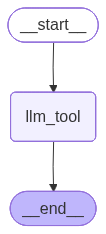

In [36]:
from IPython. display import Image, display
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

builder.add_node("llm_tool", llm_tool)
builder.add_edge(START, "llm_tool")
builder.add_edge("llm_tool", END)

graph = builder.compile()
builder.add_edge("llm_tool", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
from langchain_core.messages import HumanMessage

messages = graph.invoke({"message": [HumanMessage(content="what is 2 + 2")]})

for message in messages["messages"]:
    message.pretty_print()

ValueError: No message found in input

In [42]:
tools = [add]

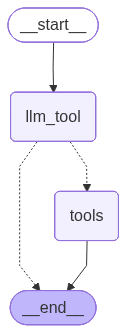

ValueError: No message found in input

In [44]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

builder.add_node("llm_tool", llm_tool)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "llm_tool")

builder.add_conditional_edges(
    "llm_tool",
    # if the latest message (result) from assistant is a tool call, -> tools_condition routes to tools
    # otherwise, it goes to END
    tools_condition,
)

builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



##Invocation

messages = graph.invoke({"message": [HumanMessage(content="what is 2 + 2")]})

for message in messages["message"]:
    message.pretty_print()

In [47]:
from langchain.schema import AIMessage

def llm_tool(state: State):
    # call the LLM (adjust depending on what your llm_with_tools.invoke returns)
    res = llm_with_tools.invoke(state["message"])

    # If res is a plain string, wrap it. If it's already an AIMessage, keep it.
    if isinstance(res, AIMessage):
        ai_msg = res
    elif isinstance(res, str):
        ai_msg = AIMessage(content=res)
    else:
        # best-effort: if it's an LLM result object that contains text
        text = getattr(res, "content", None) or getattr(res, "text", None) or str(res)
        ai_msg = AIMessage(content=text)

    # append the assistant message to history
    return {"message": state["message"] + [ai_msg]}

In [48]:
result = llm_tool({"message": [HumanMessage(content="what is 2 + 2?")]})

In [49]:
result

{'message': [HumanMessage(content='what is 2 + 2?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XSft84zqC2xyH0cfg3DTeX9N', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 79, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CNKWh0KPLRxdrPqswn1IPtVmeRREy', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--22ac8dae-be4d-4021-9ef8-aa78e06be493-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'call_XSft84zqC2xyH0cfg3DTeX9N', 'type': 'tool_call'}], usage_metadata={'input_tokens': 79, 'output_